In [1]:
%load_ext autoreload
%autoreload 2

# Single day FWI Reanalysis forecast using 2 day Forcings input

We will do single day FWI-Reanalysis forecast using 2-days input of Temperature, Relative humidity, Total precipitation, and Wind speed. The sample data must span for at least 2 consecutive days. The file format of the stored data should be in netCDF4 format. A pretrained model checkpoint conrresponding to the input and forecast timespan will be required as well.

#### Changing working directory to import modules naturally

In [2]:
import os
os.chdir('../src')
from train import str2num, get_hparams, get_model

#### Importing installed modules

In [3]:
# General functionality
import random
from glob import glob
from argparse import Namespace
import pickle
import tempfile

# Keep the execution uncomplicated
import logging, sys
logging.disable(sys.maxsize)
import warnings
warnings.filterwarnings('ignore')

# Ploting purposes
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Scientific computing
import numpy as np
import torch
from scipy.special import inv_boxcox

# Helper modules
import pytorch_lightning as pl
from pytorch_lightning import Trainer

#### Ensuring reproducibility

In [4]:
SEED = 2334
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)
random.seed(SEED)

#### Downloading Data
The next cell downloads the required data for performing inference using 2 (4) days weather forcings for 1 (10) days FWI prediction. The data is stored in `./deepfwi-mini-sample/fwi-forcings` and `./deepfwi-mini-sample/fwi-reanalysis`.

If you already have the data downloaded, comment the cell below and please place it in the directory structure explained above.

os.chdir('../examples')
!gsutil cp -r gs://deepfwi-mini-sample .
os.chdir('../src')

#### Creating pickled list of test-set files

In [5]:
# Only the files needed for output variable are specified.
# Input variable files for corresponding dates are auto-deduced.
test_out_files = [f'./deepfwi-mini-sample/fwi-reanalysis/ECMWF_FWI_201912{x:02}_1200_hr_fwi_e5.nc' for x in range(1, 3)]
print("First few files...", *test_out_files[:3], sep='\n')

# Pickling the list which can be used later
with tempfile.NamedTemporaryFile(delete=False) as tmp:
    pickle.dump(test_out_files, tmp)
    test_set_path = tmp.name

First few files...
./deepfwi-mini-sample/fwi-reanalysis/ECMWF_FWI_20191201_1200_hr_fwi_e5.nc
./deepfwi-mini-sample/fwi-reanalysis/ECMWF_FWI_20191202_1200_hr_fwi_e5.nc


#### Adjusting the knobs

In [9]:
# Storing hyperparamters and configuration in a dictionary
hparams_dict = get_hparams(
    # Feature density of U-Net layers
    init_features=16,
    # Number of input channels (=4*input days)
    in_days=2,
    # Number of prediction channels (=output days)
    out_days=1,
    # Loss metric
    loss='mse',
    # Batch size
    batch_size=1,
    # Number of GPUs to use
    gpus=1,
    # Turn on temporal and spatial constraints for case-study in Australia
    case_study=False,
    # Whether to ignore fire-prone regions
    clip_fwi=False,
    # Pickled list of output files in test-set
    test_set=test_set_path,
    # Model architecture
    model='unet_tapered',
    # Output dataloader
    out='fwi_reanalysis',
    # Directory with FWI Forcings input
    forcings_dir='./deepfwi-mini-sample/fwi-forcings',
    # Directory with FWI Renanlysis output
    reanalysis_dir='./deepfwi-mini-sample/fwi-reanalysis',
    # Custom mask stored as numpy array
    mask=False,
    # Model checkpoint file used to load the pretrained weights
    checkpoint_file='/Users/Dhruv/wildfire-forecasting/examples/epoch_41_100.ckpt'
    )

# Converting the dictionary to Namespace for easier access
hparams = Namespace(**hparams_dict)

 |  init-features -> 16             
 |        in-days -> 2              
 |       out-days -> 1              
 |         epochs -> 100            
 |  learning-rate -> 0.001          
 |           loss -> mse            
 |     batch-size -> 1              
 |          split -> 0.2            
 |      use-16bit -> True           
 |           gpus -> 1              
 |          optim -> one_cycle      
 |        dry-run -> False          
 |        find-lr -> False          
 |      search-bs -> False          
 |     case-study -> False          
 |       clip-fwi -> False          
 |          model -> unet_tapered   
 |            out -> fwi_reanalysis 
 |   forecast-dir -> /Users/Dhruv/wildfire-forecasting/src
 |   forcings-dir -> ./deepfwi-mini-sample/fwi-forcings
 | reanalysis-dir -> ./deepfwi-mini-sample/fwi-reanalysis
 |        frp-dir -> /Users/Dhruv/wildfire-forecasting/src
 |           mask -> False          
 |       test-set -> /var/folders/qd/v4mk0cf97rg_d28qjwh17n000000

#### Setting the flag for inference

In [10]:
hparams.eval = True

#### Preparing the model

In [11]:
# Create the model architecture and attach with the data
model = get_model(hparams)
model.load_state_dict(torch.load(hparams.checkpoint_file)["state_dict"])

# Load the pretrained weights


# Turn off the gradients
model.eval();

KeyError: 191201

### Manual inference

In [9]:
# Input tensor
x = model.data[0][0].unsqueeze(0)

# Ground truth tensor
y = model.data[0][1].unsqueeze(0)

# Predicted tensor
y_hat = model(x).detach()

# Masking the prediction as done with the ground truth
y_hat[torch.isnan(y)] = torch.tensor(float('nan'))

NameError: name 'model' is not defined

#### Input variables

NameError: name 'x' is not defined

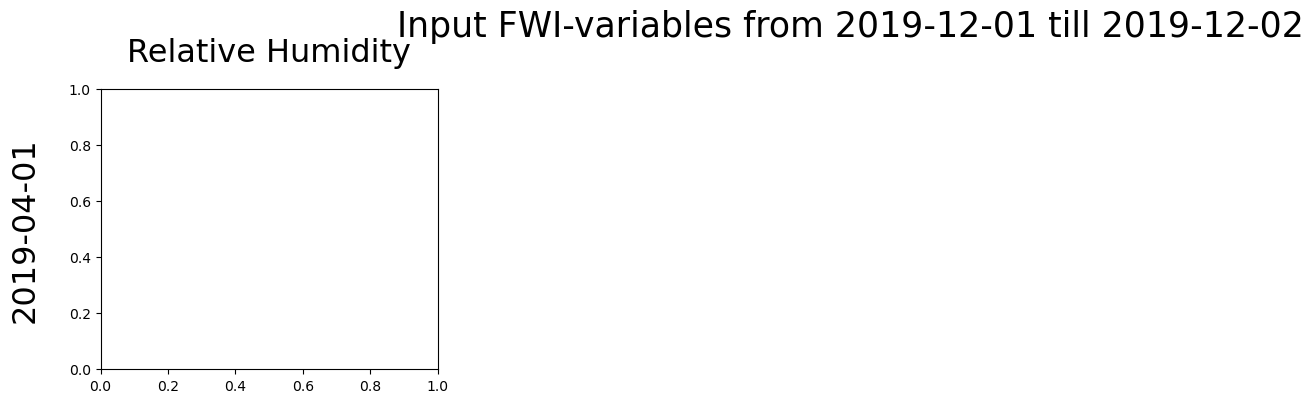

In [29]:
fig=plt.figure(figsize=(20, hparams.in_days*4))
fig.suptitle('Input FWI-variables from 2019-12-01 till 2019-12-02', fontsize=25)
for i in range(hparams.in_days):
    for j in range(4):
        ax = fig.add_subplot(hparams.in_days, 4, 4*i+j+1)
        if i==0:
            if j==0:
                ax.set_title('Relative Humidity',fontsize='23', pad=20)
            elif j==1:
                ax.set_title('Temperature',fontsize='23', pad=20)
            elif j==2:
                ax.set_title('Precipitation',fontsize='23', pad=20)
            else:
                ax.set_title('Wind speed',fontsize='23', pad=20)
        if j==0:
            ax.set_ylabel(f'2019-04-{i+1:02}', fontsize='23', labelpad=20)
        if j==1:
            plt.imshow(x.squeeze()[4*i+j], cmap='gist_ncar')
        elif j==2:
            plt.imshow(x.squeeze()[4*i+j], cmap='flag')
        else:
            plt.imshow(x.squeeze()[4*i+j], cmap='hsv')
plt.show()

*Helper function to add colorbar in the plots.*

In [30]:
def plot(im, title):
    fig, ax = plt.subplots(figsize = (20,10))
    fig.suptitle(title, fontsize=25)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('bottom', size='5%', pad=0.5)
    im = ax.imshow(im, cmap='jet')
    fig.colorbar(im, cax=cax, orientation='horizontal')

#### Ground truth

In [31]:
plot(y.squeeze(), 'Observed FWI-reanalysis')

NameError: name 'y' is not defined

#### Prediction

In [32]:
plot(y_hat.squeeze(), f'Predicted FWI-reanalysis\nAccuracy: \
{((y-y_hat).abs()<9.4)[model.data.mask.expand_as(y)].float().mean()*100:.2f}%*')

NameError: name 'y_hat' is not defined

<i>*Using half of MAD as the threshold

#### Prediction error

In [33]:
plot((y-y_hat).abs().squeeze(), f"Error in predicted FWI-reanalysis\nMAE: \
{((y-y_hat).abs())[model.data.mask.expand_as(y)].float().mean():.3f}")

NameError: name 'y' is not defined

## Case study

The receptive field size for input stays the same as for global prediction. After getting the global predictions we extract only the values falling within the case-study region coordinates.

In [34]:
y_case = y[0][0][355:480, 400:550]
y_hat_case = y_hat[0][0][355:480, 400:550]
mask_case = model.data.mask[355:480, 400:550]

NameError: name 'y' is not defined

#### Ground truth

In [35]:
plot(y_case.squeeze(), 'Observed FWI-reanalysis in the case-study region')

NameError: name 'y_case' is not defined

#### Prediction

In [36]:
plot(y_hat_case.squeeze(), f'Predicted FWI-reanalysis in the case-study region\nAccuracy: \
{((y_case-y_hat_case).abs()<9.4)[mask_case.expand_as(y_case)].float().mean()*100:.2f}%*')

NameError: name 'y_hat_case' is not defined

<i>*Using half of MAD as the threshold

#### Prediction error

In [ ]:
plot((y_case-y_hat_case).abs().squeeze(), f"Error in predicted FWI-reanalysis\nMAE: \
{((y_case-y_hat_case).abs())[mask_case.expand_as(y_case)].float().mean():.3f}")

## Model trained with Box-Cox transformation

To do inference on the model trained with Box-Cox transformed output variable, we would need the corresponding lambda value for the inverse transformation. The chekpoint used here requires the lambda = 0.1182

In [ ]:
hparams.boxcox = 0.1182
hparams.checkpoint_file='../src/model/checkpoints/pre_trained/7/2_1/epoch_41_100.ckpt'

#### Preparing the model

In [ ]:
# Create the model architecture and attach with the data
model = get_model(hparams)

# Load the pretrained weights
model.load_state_dict(torch.load(hparams.checkpoint_file)["state_dict"])

# Turn off the gradients
model.eval();

#### Getting the data sample

In [ ]:
# Input tensor
x = model.data[0][0].unsqueeze(0)

# Ground truth tensor
y = model.data[0][1].unsqueeze(0)

# Predicted tensor
y_hat = model(x).detach()
y_hat = torch.from_numpy(
    inv_boxcox(y_hat.cpu().numpy(), model.hparams.boxcox)
)

# Masking the prediction as done with the ground truth
y_hat[torch.isnan(y)] = torch.tensor(float('nan'))

#### Prediction

In [ ]:
plot(y_hat.squeeze(), f'Predicted FWI-reanalysis after Box-Cox transformation\nAccuracy: \
{((y-y_hat).abs()<9.4)[model.data.mask.expand_as(y)].float().mean()*100:.2f}%*')

<i>*Using half of MAD as the threshold

#### Prediction error

In [ ]:
plot((y-y_hat).abs().squeeze(), f"Error in predicted FWI-reanalysis after Box-Cox transformation\nMAE: \
{((y-y_hat).abs())[model.data.mask.expand_as(y)].float().mean():.3f}")

### Bulk inference

Instead of passing inputs manually to the model, the `Trainer` can be used. It will run the prepared model over the entire data and generate the result metrics.

In [ ]:
# Trainer object responsible for running the model
trainer = pl.Trainer(gpus=hparams.gpus)

# Running inference with the supplied model
trainer.test(model)

## Conclusion

We did single day global forecast using 2-day input of Relative humidty, Temperature, Total precipitation, and Wind speed. The model gives accuracy of 93.36%, *MAE* of 2.608, and *MSE* of 21.452. We also looked at the error distribution of the prediction across the various regions.